# Neural Cleanse

Some codes are borrowed from **TrojanZoo**.

In [1]:
import sys, os
EXT_DIR = ['..', '../models/cifar_10']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from scipy.optimize import linprog
from tqdm import tqdm
from math import ceil
import matplotlib.pyplot as plt
import PIL.Image as Image
# Models
import narrow_vgg, narrow_resnet, narrow_mobilenetv2, narrow_wideresidual
import vgg, resnet, mobilenetv2, wideresidual


"""
Configurations
"""
use_gpu = True # use GPU or CPU
model_arch = 'vgg'
dataset_path = '../datasets/data_cifar'
test_num = 100 # test input number
class_num = 10 # output class(es) num
target_label = 2 # backdoor attack target

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '2' # select GPU if necessary
    device = 'cuda'
else:
    device = 'cpu'

def generate_dataloader(dataset_path='./dataset/', batch_size=4, train=False):
    if train:
        train_data  = datasets.CIFAR10(root=dataset_path, train=True, download=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
        return train_data_loader
    else:
        test_data  = datasets.CIFAR10(root=dataset_path, train=False, download=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        )
        test_data_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
        return test_data_loader

def load_a_batch_of_data(input_num):
    dataloader = generate_dataloader(dataset_path=dataset_path, batch_size=input_num)
    return next(iter(dataloader))

preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
reverse_preprocess = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

def attack_demo(ori_x, trigger, channels=3, example_num=2):
    demo_x = ori_x[:example_num]
    for i in range(example_num):
        demo = plt.subplot(example_num, 2, i * 2 + 1)
        if channels == 3: demo.imshow(demo_x[i].permute(1, 2, 0))
        else: demo.imshow(demo_x[i, 0])
        demo.axis('off')
        demo.set_title('Original')
        demo = plt.subplot(example_num, 2, i * 2 + 2)
        if channels == 3: demo.imshow((demo_x[i] + trigger).clamp(0., 1.).permute(1, 2, 0))
        else:
            if len(trigger.shape) == 3: demo.imshow(demo_x[i, 0] + trigger[0])
            else: demo.imshow(demo_x[i, 0] + trigger)
        demo.axis('off')
        demo.set_title('Attacked')
    plt.show()

def attack_demo_mix(ori_x, trigger, trigger_mask, trigger_alpha, channels=3, example_num=2):
    demo_x = ori_x[:example_num]
    for i in range(example_num):
        demo = plt.subplot(example_num, 2, i * 2 + 1)
        if channels == 3: demo.imshow(demo_x[i].permute(1, 2, 0))
        else: raise NotImplementedError("1 channel not supported")
        demo.axis('off')
        demo.set_title('Original')
        demo = plt.subplot(example_num, 2, i * 2 + 2)
        if channels == 3: demo.imshow((torch.mul(demo_x[i, :, :, :] * (1 - trigger_alpha) + trigger * trigger_alpha, 1 - trigger_mask) + torch.mul(demo_x[i, :, :, :], trigger_mask)).clamp(0., 1.).permute(1, 2, 0))
        else: raise NotImplementedError("1 channel not supported")
        demo.axis('off')
        demo.set_title('Attacked')
    plt.show()

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

Inputs for testing at the end:

In [2]:
test_input, test_sources = load_a_batch_of_data(input_num=test_num)
test_input = test_input[test_sources != target_label]
test_input_ori = reverse_preprocess(test_input)
test_sources = test_sources[test_sources != target_label]

Load a model to run NC:

In [11]:
"""Select your model"""
# model_path = '../checkpoints/cifar_10/%s_sra.ckpt' % model_arch
model_path = '../checkpoints/cifar_10/%s_0.ckpt' % model_arch
# model_path = '../checkpoints/cifar_10/%s_poisoned.ckpt' % model_arch

if model_arch == 'vgg': model = vgg.vgg16_bn() # complete vgg model
elif model_arch == 'resnet': model = resnet.resnet110() # complete resnet model
elif model_arch == 'mobilenetv2': model = mobilenetv2.mobilenetv2() # complete mobilenetv2 model
elif model_arch == 'wideresidual': model = wideresidual.wideresnet() # complete wideresidual model

model.eval()
model.load_state_dict(torch.load(model_path))
model.to(device=device)
print("Model loaded on '{}' successfully!".format(device))

Model loaded on 'cuda' successfully!


## Major NC code

In [4]:
import torch
import torch.optim as optim
import numpy as np

import os
import time
import datetime
from tqdm import tqdm

def to_numpy(x, **kwargs) -> np.ndarray:
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    return np.array(x, **kwargs)

# Project function
def tanh_func(x: torch.Tensor, plant_strategy='nc') -> torch.Tensor:
    if plant_strategy == 'nc': return x.tanh().add(1).mul(0.5)
    else: return x.tanh()

class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self, name: str, fmt: str = ':f'):
        self.name: str = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# Neural Cleanse!
class NeuralCleanse():
    name: str = 'neural_cleanse'

    def __init__(self, model, epoch: int = 10, batch_size = 32,
                 init_cost: float = 1e-3, cost_multiplier: float = 1.5, patience: float = 10,
                 attack_succ_threshold: float = 0.99, early_stop_threshold: float = 0.99,
                 show_every = 5, loader=None):

        self.epoch: int = epoch

        self.init_cost = init_cost
        self.cost_multiplier_up = cost_multiplier
        self.cost_multiplier_down = cost_multiplier ** 1.5

        self.patience: float = patience
        self.attack_succ_threshold: float = attack_succ_threshold

        self.early_stop = True
        self.early_stop_threshold: float = early_stop_threshold
        self.early_stop_patience: float = self.patience * 2

        # My configuration
        self.device=device
        self.folder_path = '../defenses'
        self.target_class = target_label
        self.model = model
        self.num_classes = class_num
        self.criterion = torch.nn.CrossEntropyLoss()
        if loader is None: self.loader = generate_dataloader(dataset_path=dataset_path, batch_size=batch_size, train=True)
        else: self.loader = loader
        self.shape = torch.Size([3, 32, 32])
        self.tqdm = True
        self.show_every = show_every

    def detect(self):
        # self.real_mask = self.attack.mark.mask
        mark_list, mask_list, loss_list = self.get_potential_triggers()
        mask_norms = mask_list.flatten(start_dim=1).norm(p=1, dim=1)
        print('mask norms: ', mask_norms)
        # print('mask MAD: ', normalize_mad(mask_norms))
        print('loss: ', loss_list)
        # print('loss MAD: ', normalize_mad(loss_list))

        # if not self.random_pos:
        #     overlap = jaccard_idx(mask_list[self.attack.target_class], self.real_mask,
        #                           select_num=self.attack.mark.mark_height * self.attack.mark.mark_width)
        #     print(f'Jaccard index: {overlap:.3f}')

    def get_potential_triggers(self):#-> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mark_list, mask_list, loss_list = [], [], []
        # todo: parallel to avoid for loop
        file_path = os.path.normpath(os.path.join(
            self.folder_path, 'NC_target_%d' % self.target_class + '.npz'))
        # for label in range(self.num_classes):
        for label in [self.target_class]:
            print('Class: %d/%d' % (label + 1, self.num_classes))
            mark, mask, loss = self.remask(label)
            mark_list.append(mark)
            mask_list.append(mask)
            loss_list.append(loss)
            # overlap = jaccard_idx(mask, self.real_mask,
            #                         select_num=self.attack.mark.mark_height * self.attack.mark.mark_width)
            # print(f'Jaccard index: {overlap:.3f}')
            np.savez(file_path, mark_list=[to_numpy(mark) for mark in mark_list],
                     mask_list=[to_numpy(mask) for mask in mask_list],
                     loss_list=loss_list)
            print('Defense results saved at: ' + file_path)
        mark_list = torch.stack(mark_list)
        mask_list = torch.stack(mask_list)
        loss_list = torch.as_tensor(loss_list)
        return mark_list, mask_list, loss_list

    def loss_fn(self, _input, _label, Y, mask, mark, label):
        X = (_input + mask * (mark - _input)).clamp(0., 1.)
        Y = label * torch.ones_like(_label, dtype=torch.long)
        _output = self.model(preprocess(X))
        return self.criterion(_output, Y)

    def remask(self, label: int):
        epoch = self.epoch
        # no bound
        atanh_mark = torch.randn(self.shape, device=self.device)
        atanh_mark.requires_grad_()
        atanh_mask = torch.randn(self.shape[1:], device=self.device)
        # atanh_mask = torch.ones(self.shape[1:], device=self.device)
        atanh_mask.requires_grad_()
        mask = tanh_func(atanh_mask)    # (h, w)
        mark = tanh_func(atanh_mark)    # (c, h, w)

        optimizer = optim.Adam(
            [atanh_mark, atanh_mask], lr=0.1, betas=(0.5, 0.9))
        optimizer.zero_grad()

        cost = self.init_cost
        cost_set_counter = 0
        cost_up_counter = 0
        cost_down_counter = 0
        cost_up_flag = False
        cost_down_flag = False

        # best optimization results
        norm_best = float('inf')
        mask_best = None
        mark_best = None
        entropy_best = None

        # counter for early stop
        early_stop_counter = 0
        early_stop_norm_best = norm_best

        losses = AverageMeter('Loss', ':.4e')
        entropy = AverageMeter('Entropy', ':.4e')
        norm = AverageMeter('Norm', ':.4e')
        acc = AverageMeter('Acc', ':6.2f')

        for _epoch in range(epoch):
            losses.reset()
            entropy.reset()
            norm.reset()
            acc.reset()
            epoch_start = time.perf_counter()
            loader = self.loader
            if self.tqdm:
                loader = tqdm(self.loader)
            for _input, _label in loader:
                _input = reverse_preprocess(_input.to(device=device))
                # _input = _input.to(device=device)
                _label = _label.to(device=device)
                batch_size = _label.size(0)
                X = (_input + mask * (mark - _input)).clamp(0., 1.)
                Y = label * torch.ones_like(_label, dtype=torch.long)
                _output = self.model(preprocess(X))
                # _output = self.model(X)

                batch_acc = Y.eq(_output.argmax(1)).float().mean()
                batch_entropy = self.loss_fn(_input, _label, Y, mask, mark, label)
                batch_norm = mask.norm(p=1)
                batch_loss = batch_entropy + cost * batch_norm # NC loss function

                acc.update(batch_acc.item(), batch_size)
                entropy.update(batch_entropy.item(), batch_size)
                norm.update(batch_norm.item(), batch_size)
                losses.update(batch_loss.item(), batch_size)

                batch_loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                mask = tanh_func(atanh_mask)    # (h, w)
                mark = tanh_func(atanh_mark)    # (c, h, w)
            epoch_time = str(datetime.timedelta(seconds=int(
                time.perf_counter() - epoch_start)))
            pre_str = 'Epoch: {}/{}'.format(_epoch + 1, epoch)
            _str = ' '.join([
                f'Loss: {losses.avg:.4f},'.ljust(20),
                f'Acc: {acc.avg:.2f}, '.ljust(20),
                f'Norm: {norm.avg:.4f},'.ljust(20),
                f'Entropy: {entropy.avg:.4f},'.ljust(20),
                f'Time: {epoch_time},'.ljust(20),
            ])
            print(pre_str, _str)

            # check to save best mask or not
            if acc.avg >= self.attack_succ_threshold and norm.avg < norm_best:
                mask_best = mask.detach()
                mark_best = mark.detach()
                norm_best = norm.avg
                entropy_best = entropy.avg

            # check early stop
            if self.early_stop:
                # only terminate if a valid attack has been found
                if norm_best < float('inf'):
                    if norm_best >= self.early_stop_threshold * early_stop_norm_best:
                        early_stop_counter += 1
                    else:
                        early_stop_counter = 0
                early_stop_norm_best = min(norm_best, early_stop_norm_best)

                if cost_down_flag and cost_up_flag and early_stop_counter >= self.early_stop_patience:
                    print('early stop')
                    break

            # check cost modification
            if cost == 0 and acc.avg >= self.attack_succ_threshold:
                cost_set_counter += 1
                if cost_set_counter >= self.patience:
                    cost = self.init_cost
                    cost_up_counter = 0
                    cost_down_counter = 0
                    cost_up_flag = False
                    cost_down_flag = False
                    print('initialize cost to %.2f' % cost)
            else:
                cost_set_counter = 0

            if acc.avg >= self.attack_succ_threshold:
                cost_up_counter += 1
                cost_down_counter = 0
            else:
                cost_up_counter = 0
                cost_down_counter += 1

            if cost_up_counter >= self.patience:
                cost_up_counter = 0
                print('up cost from %.4f to %.4f' % (cost, cost * self.cost_multiplier_up))
                cost *= self.cost_multiplier_up
                cost_up_flag = True
            elif cost_down_counter >= self.patience:
                cost_down_counter = 0
                print('down cost from %.4f to %.4f' % (cost, cost / self.cost_multiplier_down))
                cost /= self.cost_multiplier_down
                cost_down_flag = True
            if mask_best is None:
                mask_best = tanh_func(atanh_mask).detach()
                mark_best = tanh_func(atanh_mark).detach()
                norm_best = norm.avg
                entropy_best = entropy.avg
            if _epoch % self.show_every == 0:
                show_img((mark * mask).cpu().detach(), channels=3, title='Restored trigger\nat epoch %d' % (_epoch))
        atanh_mark.requires_grad = False
        atanh_mask.requires_grad = False

        # self.attack.mark.mark = mark_best
        # self.attack.mark.alpha_mark = mask_best
        # self.attack.mark.mask = torch.ones_like(mark_best, dtype=torch.bool)
        # self.attack.validate_fn()
        return mark_best, mask_best, entropy_best


Class: 3/10


100%|██████████| 1563/1563 [01:22<00:00, 18.89it/s]

Epoch: 1/10 Loss: 0.1049,        Acc: 1.00,           Norm: 81.6691,       Entropy: 0.0232,     Time: 0:01:22,      


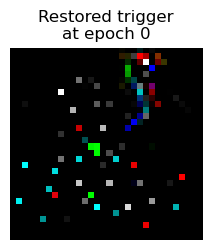

100%|██████████| 1563/1563 [01:22<00:00, 18.92it/s]


Epoch: 2/10 Loss: 0.0675,        Acc: 1.00,           Norm: 54.4433,       Entropy: 0.0130,     Time: 0:01:22,      
up cost from 0.0010 to 0.0015


100%|██████████| 1563/1563 [01:22<00:00, 19.06it/s]

Epoch: 3/10 Loss: 0.0950,        Acc: 1.00,           Norm: 51.8707,       Entropy: 0.0172,     Time: 0:01:22,      


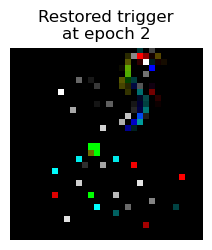

100%|██████████| 1563/1563 [01:21<00:00, 19.08it/s]


Epoch: 4/10 Loss: 0.0933,        Acc: 1.00,           Norm: 51.1577,       Entropy: 0.0166,     Time: 0:01:21,      
up cost from 0.0015 to 0.0023


100%|██████████| 1563/1563 [01:21<00:00, 19.06it/s]

Epoch: 5/10 Loss: 0.1315,        Acc: 1.00,           Norm: 49.6585,       Entropy: 0.0198,     Time: 0:01:21,      


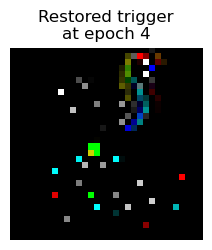

100%|██████████| 1563/1563 [01:23<00:00, 18.68it/s]


Epoch: 6/10 Loss: 0.1311,        Acc: 1.00,           Norm: 49.7800,       Entropy: 0.0191,     Time: 0:01:23,      
up cost from 0.0023 to 0.0034


100%|██████████| 1563/1563 [01:21<00:00, 19.06it/s]

Epoch: 7/10 Loss: 0.1886,        Acc: 0.99,           Norm: 47.6431,       Entropy: 0.0278,     Time: 0:01:21,      


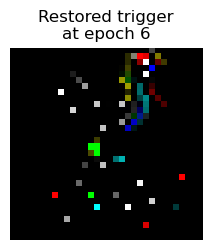

100%|██████████| 1563/1563 [01:22<00:00, 18.98it/s]


Epoch: 8/10 Loss: 0.1880,        Acc: 0.99,           Norm: 47.8147,       Entropy: 0.0266,     Time: 0:01:22,      
up cost from 0.0034 to 0.0051


100%|██████████| 1563/1563 [01:22<00:00, 19.04it/s]

Epoch: 9/10 Loss: 0.2692,        Acc: 0.99,           Norm: 45.4934,       Entropy: 0.0389,     Time: 0:01:22,      


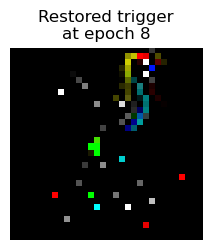

100%|██████████| 1563/1563 [01:21<00:00, 19.06it/s]

Epoch: 10/10 Loss: 0.2680,        Acc: 0.99,           Norm: 45.4369,       Entropy: 0.0380,     Time: 0:01:21,      
up cost from 0.0051 to 0.0076
Defense results saved at: ../defenses/NC_target_2.npz
mask norms:  tensor([45.9974], device='cuda:0')
loss:  tensor([0.0380])


In [6]:
epoch = 10
batch_size = 32
init_cost = 1e-3
patience = 2
attack_succ_threshold = 0.95
show_every = 2
# loader = generate_dataloader(dataset_path=dataset_path, batch_size=32, train=True)

defense = NeuralCleanse(
    model=model,
    epoch=epoch,
    batch_size=batch_size,
    init_cost=init_cost,
    patience=patience,
    attack_succ_threshold=attack_succ_threshold,
    show_every=show_every,
    # loader=loader,
    )
defense.detect()

### Show NC Results

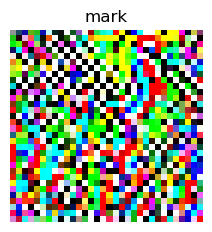

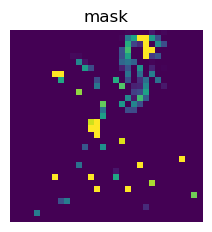

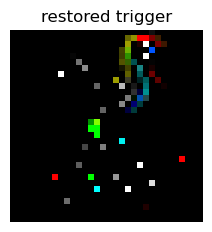

In [7]:
# results = np.load('../defenses/NC_target_%s.npz' % target_label)
# results = np.load('../defenses/NC_target_%s_sra_4.npz' % target_label)
results = np.load('../defenses/NC_target_%s_clean_3.npz' % target_label)
# results = np.load('../defenses/NC_target_%s_poisoned_3.npz' % target_label)
mark_list = results['mark_list']
mask_list = results['mask_list']
loss_list = results['loss_list']

for i in range(1):
    mark = torch.tensor(mark_list[i])
    mask = torch.tensor(mask_list[0])
    show_img(mark, title='mark')
    show_img(mask, channels=1, title='mask')
    show_img(mark * mask, title='restored trigger') # restored trigger

### Test NC Results

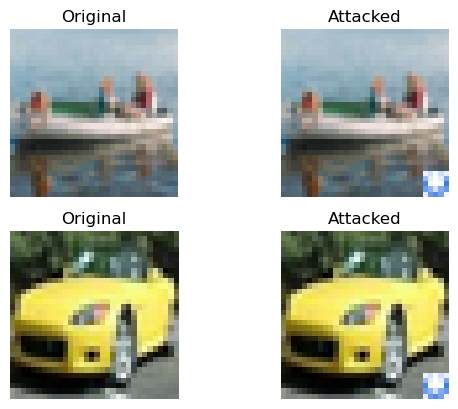

Min: tensor(0.)
Max: tensor(1.)
L1 norm: tensor(61.4588)
L2 norm: tensor(7.3162)
L_infin norm: tensor(1.)
Prediction: tensor([8, 1, 9, 7, 0, 3, 1, 6, 8, 9, 3, 3, 9, 0, 9, 6, 3, 5, 1, 6, 6, 5, 7, 3,
        1, 9, 8, 9, 6, 9, 7, 0, 9, 4, 4, 8, 5, 5, 9, 5, 3, 3, 8, 3, 3, 1, 7, 6,
        7, 8, 1, 6, 9, 0, 8, 1, 3, 0, 3, 9, 6, 6, 6, 4, 4, 9, 8, 3, 0, 4, 8, 9,
        3, 8, 0, 6, 8, 5, 4, 6, 7, 5, 8, 9, 0, 4])
Clean acc:	94.18604278564453%
Attack acc:	0.0%


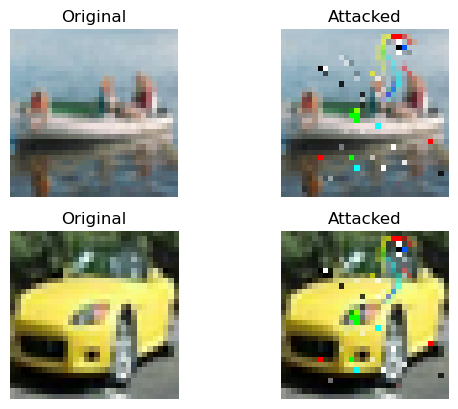

Min: tensor(0.)
Max: tensor(1.)
L1 norm: tensor(73.9252)
L2 norm: tensor(7.0662)
L_infin norm: tensor(1.)
Prediction: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Clean acc:	0.0%
Attack acc:	100.0%


In [12]:
def attack_demo(ori_x, trigger, trigger_mask, channels=3, example_num=2):
    assert channels == 3
    demo_x = ori_x[:example_num]
    for i in range(example_num):
        demo = plt.subplot(example_num, 2, i * 2 + 1)
        demo.imshow(demo_x[i].permute(1, 2, 0))
        demo.axis('off')
        demo.set_title('Original')
        demo = plt.subplot(example_num, 2, i * 2 + 2)
        demo.imshow((demo_x[i] + trigger_mask * (trigger - demo_x[i])).clamp(0., 1.).permute(1, 2, 0))
        demo.axis('off')
        demo.set_title('Attacked')
    plt.show()

## Real trigger attack
trigger_path = '../triggers/phoenix_corner.png'
real_mark = Image.open(trigger_path).convert("RGB")
trigger_transform_no_normalize=transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor()
])
real_mark = trigger_transform_no_normalize(real_mark)
real_mask = torch.zeros((32, 32))
real_mask[27:, 27:] = 1
attack_demo(ori_x=test_input_ori, trigger=real_mark, trigger_mask=real_mask, channels=3, example_num=2)
mask_mark = real_mark
print("Min:", torch.min(mask_mark))
print("Max:", torch.max(mask_mark))
print("L1 norm:", torch.sum(mask_mark.abs()))
print("L2 norm:", torch.sqrt(torch.sum(mask_mark * mask_mark)))
print("L_infin norm:", torch.max(mask_mark.abs()))
prediction = model(preprocess((test_input_ori + real_mask * (real_mark - test_input_ori)).clamp(0., 1.)).to(device=device))
prediction = torch.argmax(prediction.to('cpu'), dim=-1)
print("Prediction:", prediction)
print("Clean acc:\t{}%".format(torch.sum(prediction == test_sources) / test_input.shape[0] * 100))
print("Attack acc:\t{}%".format(torch.sum(prediction == target_label) / test_input.shape[0] * 100))


## NC attack: x' = x + mask * (mark - x)
factor = 1.
attack_demo(ori_x=test_input_ori, trigger=factor * mark, trigger_mask=mask, channels=3, example_num=2)
mask_mark = factor * mark * mask
print("Min:", torch.min(mask_mark))
print("Max:", torch.max(mask_mark))
print("L1 norm:", torch.sum(mask_mark.abs()))
print("L2 norm:", torch.sqrt(torch.sum(mask_mark * mask_mark)))
print("L_infin norm:", torch.max(mask_mark.abs()))
prediction = model(preprocess((test_input_ori + factor * mask * (mark - test_input_ori)).clamp(0., 1.)).to(device=device))
prediction = torch.argmax(prediction.to('cpu'), dim=-1)
print("Prediction:", prediction)
print("Clean acc:\t{}%".format(torch.sum(prediction == test_sources) / test_input.shape[0] * 100))
print("Attack acc:\t{}%".format(torch.sum(prediction == target_label) / test_input.shape[0] * 100))